In [1]:
#Imports
from scripts import bookdatafunctions as bdf
from scripts import corpusMLfunctions as cmf
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, logging
from tqdm import tqdm
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
import optuna
import json
import multiprocessing as mp

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_BEG = "SnippetDatasets/"
BASE_MID = "sniplen_"
BASE_END = ".jsonl"
KEYLISTS = "Keylists.jsonl"
SNIPPET_LENS = ['5','10','25','50','75','100']
CHOSEN_PARAMS = [{'c':0.15, 'tol':1e-6}, {'c':0.4, 'tol':1e-4}, {'c':5, 'tol':1e-4}, {'c':15, 'tol':1e-3}, {'c':60, 'tol':1e-3}, {'c':120, 'tol':1e-3}]
logging.set_verbosity(40)

In [3]:
keylists = []
with open(KEYLISTS, 'r') as f:
    for line in f:
        keylists.append(json.loads(line))

In [4]:
def do_nothing(ex):
    return ex.lower()

def conllu_tokenizer(ex):
    return ex.replace("\n", "\t").replace("|", "\t").split("\t")

def whitespace_tokenizer(ex):
    return ex.split(" ")

In [5]:
def manualStudy(params, SNIPPET_LENS, keylists, i, k, overwrite: bool=True):
    filename = "TestResults/ParamOptim_List_"+str(i)+"_SnipLen_"+str(SNIPPET_LENS[k])+"_Results.jsonl"
    if overwrite or not os.path.exists(filename):
        train_keys = keylists[i]['train_keys']
        eval_keys = keylists[i]['eval_keys']
        train_dss = cmf.combineSnippedBooksToDS(train_keys, SNIPPET_LENS[k], BASE_BEG)
        eval_dss = cmf.combineSnippedBooksToDS(eval_keys, SNIPPET_LENS[k], BASE_BEG)
        vectorizer = TfidfVectorizer(norm='l2', tokenizer=conllu_tokenizer, preprocessor=do_nothing, max_features=2000).fit(train_dss['conllu'])

        vecd_train_data = vectorizer.transform(train_dss['conllu'])
        vecd_eval_data = vectorizer.transform(eval_dss['conllu'])
        #print("Worker for length ",SNIPPET_LENS[k]," and keylist ",i," activated!")
        returnable = []
        for pair in params:
            #Train a new classifier for each set of params
            
                clf = LinearSVC(
                    random_state=42,
                    C=pair['c'],
                    tol=pair['tol']
                )
                clf.fit(vecd_train_data, train_dss['label'])
                predicted = clf.predict(vecd_eval_data)
                f1 = f1_score(eval_dss['label'], predicted, average="macro")
                #Reverse the dictionary
                index2feature = {}
                for feature,idx in vectorizer.vocabulary_.items():
                    assert idx not in index2feature #This really should hold
                    index2feature[idx]=feature
                #Now we can query index2feature to get the feature names as we need
                high_prio = {}
                # make a list of (weight, index), sort it
                for j in range(3):
                    lst=[]
                    for idx,weight in enumerate(clf.coef_[j]):
                        lst.append((weight,idx))
                    lst.sort() #sort

                    #Print first few and last few
                    #for weight,idx in lst[:20]: #first 30 (ie lowest weight)
                    #    print(index2feature[idx])
                    #print("----------------------------------------------------")
                    #Take the last 30 (lst[-30:]) but these now come from weakest to strongest
                    #so reverse the list using [::-1]
                    highest_prio = []
                    for weight,idx in lst[-100:][::-1]:
                        highest_prio.append(index2feature[idx])
                    high_prio[j] = highest_prio
                returnable.append({'keylist_id':i, 'sniplen':SNIPPET_LENS[k], 'c':pair['c'], 'tol':pair['tol'], 'f1':f1, 'important_feats_7-8':high_prio[0], 'important_feats_9-12':high_prio[1], 'important_feats_13+':high_prio[2]})
        with open(filename, 'w') as f:
            f.write('\n'.join(map(json.dumps, returnable)))

In [6]:
def testParamResults(permutations: int, keylists: list):
    pool = mp.Pool(mp.cpu_count())
    pbar = tqdm(total=permutations)
    def update(*a):
     pbar.update()
    for i in range(permutations):
        #Add to list the test results of our 'manual' study
        for k in range(len(SNIPPET_LENS)):
            pool.apply_async(manualStudy, [CHOSEN_PARAMS, SNIPPET_LENS, keylists, i, k], callback=update)
    #print("All running!")
    pool.close()
    #print("Pool closed!")
    pool.join()
    #print("Waiting done!")
    

In [7]:
#testParamResults(1, keylists)

In [8]:
def testForAllSets():
    test_results = []
    with tqdm(range(100), desc="Iterating through permutations...") as pbar:
        for i in range(2):
            train_keys = keylists[i]['train_keys']
            eval_keys = keylists[i]['eval_keys']
            test_keys = keylists[i]['train_keys']
            train_dss = [cmf.combineSnippedBooksToDS(train_keys, x, BASE_BEG) for x in SNIPPET_LENS]
            eval_dss = [cmf.combineSnippedBooksToDS(eval_keys, x, BASE_BEG) for x in SNIPPET_LENS]
            test_dss = [cmf.combineSnippedBooksToDS(test_keys, x, BASE_BEG) for x in SNIPPET_LENS]
            vectorizers = [TfidfVectorizer(norm='l2', tokenizer=conllu_tokenizer, preprocessor=do_nothing, max_features=2000).fit(x['conllu']) for x in train_dss]

            vecd_train_datas = [vectorizers[i].transform(train_dss[i]['conllu']) for i in range(len(SNIPPET_LENS))]
            vecd_eval_datas = [vectorizers[i].transform(eval_dss[i]['conllu']) for i in range(len(SNIPPET_LENS))]
            vecd_test_datas = [vectorizers[i].transform(test_dss[i]['conllu']) for i in range(len(SNIPPET_LENS))]

            classifiers = {}
            f_scores = []
            for j in range(len(SNIPPET_LENS)):
                clf = LinearSVC(
                loss='squared_hinge', penalty='l2',
                                random_state=42,
                                C=62.42249746377182,
                                tol=0.001)
                clf.fit(vecd_train_datas[j], train_dss[j]['label'])
                classifiers[SNIPPET_LENS[j]] = clf
                test_predict = clf.predict(vecd_test_datas[j])
                f_scores.append(f1_score(test_dss[j]['label'], test_predict, average="macro"))

            #Reverse the dictionary
            index2features = {}
            for i in range(len(SNIPPET_LENS)):
                index2feature = {}
                vectorizer = vectorizers[i]
                for feature,idx in vectorizer.vocabulary_.items():
                    assert idx not in index2feature #This really should hold
                    index2feature[idx]=feature
                index2features[SNIPPET_LENS[i]] = index2feature
            #Now we can query index2feature to get the feature names as we need
            highest_prios = {}
            for i in SNIPPET_LENS:
                high_prio = {}
                classifier = classifiers[i]
                index2feature = index2features[i]
                # make a list of (weight, index), sort it
                for j in range(3):
                    lst=[]
                    for idx,weight in enumerate(classifier.coef_[j]):
                        lst.append((weight,idx))
                    lst.sort() #sort

                    #Print first few and last few
                    #for weight,idx in lst[:20]: #first 30 (ie lowest weight)
                    #    print(index2feature[idx])
                    #print("----------------------------------------------------")
                    #Take the last 30 (lst[-30:]) but these now come from weakest to strongest
                    #so reverse the list using [::-1]
                    highest_prio = []
                    for weight,idx in lst[-100:][::-1]:
                        highest_prio.append(index2feature[idx])
                    high_prio[j] = high_prio
                highest_prios[i] = high_prio
            test_results.append({'id':i, 'f1s':f_scores, 'feats':highest_prios})
            pbar.update(1)
    return test_results

        


In [9]:
#results = testForAllSets()

In [10]:
#print(results)

In [11]:
from datasets import Dataset
from scripts import bookdatafunctions as bdf
def combineSnippedBooksToDS(keys: list[str], snip_len: str, cache_dir: str, cache_file:str, inc_raw_text: bool=False, inc_conllu: bool=False, inc_hpfv: bool=False, folder:str=None):
    #logging.set_verbosity(40)
    #Helper function to parse json-lines
    def jsonlReader(key: str):
        with open(folder+key+"/sniplen_"+snip_len+".jsonl") as reader:
            with open(cache_file, 'a') as tt:
                 #Only include the information we need for our specific purposes to save up on cache space
                 for line in reader:
                        if not inc_raw_text:
                            line = line[:line.find(",\"raw_text\":")] + line[line.find(",\"conllu\":"):]
                        if not inc_conllu:
                            line = line[:line.find(",\"conllu\":")] + line[line.find(",\"hp_fv\":"):]
                        if not inc_hpfv:
                            line = line[:line.find(",\"hp_fv\":")] + line[line.find("}\n"):]
                        tt.write(line)
    #Generate list of dicts, where each dict is a json-line
    for k in range(len(keys)):
            jsonlReader(keys[k])
    #Return a shuffled dataset
    return Dataset.from_json(cache_file, cache_dir=cache_dir).shuffle()

In [12]:
train_keys = keylists[93]['train_keys']
eval_keys = keylists[93]['eval_keys']
test_keys = keylists[93]['test_keys']

In [14]:
import shutil
#Also makes it easier to clean cache files and use space more efficiently
cache_dir = "cache_dir/temp"
#shutil.rmtree(cache_dir)
os.mkdir(cache_dir)
cache_file_train = cache_dir+str(0)+"_"+str(SNIPPET_LENS[0])+"_train.jsonl"
cache_file_eval = cache_dir+str(0)+"_"+str(SNIPPET_LENS[0])+"_eval.jsonl"
cache_file_test = cache_dir+str(0)+"_"+str(SNIPPET_LENS[0])+"_test.jsonl"

In [15]:
train_dss = [combineSnippedBooksToDS(train_keys, x, cache_dir, cache_file=cache_dir+str(93)+"_"+x+"_train.jsonl", folder=BASE_BEG, inc_raw_text=True) for x in SNIPPET_LENS]
eval_dss = [combineSnippedBooksToDS(eval_keys, x, cache_dir, cache_file=cache_dir+str(93)+"_"+x+"_eval.jsonl", folder=BASE_BEG, inc_raw_text=True) for x in SNIPPET_LENS]
test_dss = [combineSnippedBooksToDS(test_keys, x, cache_dir, cache_file=cache_dir+str(93)+"_"+x+"_test.jsonl", folder=BASE_BEG, inc_raw_text=True) for x in SNIPPET_LENS]

Generating train split: 159233 examples [00:00, 1414317.01 examples/s]
Generating train split: 79651 examples [00:00, 895240.58 examples/s]
Generating train split: 31909 examples [00:00, 399733.72 examples/s]
Generating train split: 15995 examples [00:00, 149983.10 examples/s]
Generating train split: 10679 examples [00:00, 128348.62 examples/s]
Generating train split: 8035 examples [00:00, 98372.48 examples/s]
Generating train split: 43391 examples [00:00, 1404445.31 examples/s]
Generating train split: 21705 examples [00:00, 703029.26 examples/s]
Generating train split: 8690 examples [00:00, 340156.99 examples/s]
Generating train split: 4352 examples [00:00, 154706.04 examples/s]
Generating train split: 2907 examples [00:00, 100312.98 examples/s]
Generating train split: 2187 examples [00:00, 78930.80 examples/s]
Generating train split: 28411 examples [00:00, 1100337.69 examples/s]
Generating train split: 14210 examples [00:00, 534764.07 examples/s]
Generating train split: 5693 examples

In [16]:
def reMapLabels(ex):
    age = int(ex['age'])
    if age < 10:
        ex['label'] = '7-10'
    elif age > 11:
        ex['label'] = '12+'
    return ex


In [17]:
train_dss = [x.map(reMapLabels) for x in train_dss]
eval_dss = [x.map(reMapLabels) for x in eval_dss]
test_dss = [x.map(reMapLabels) for x in test_dss]

Map: 100%|██████████| 1432/1432 [00:00<00:00, 20990.87 examples/s]


In [18]:
vectorizers = [TfidfVectorizer(norm='l2', tokenizer=whitespace_tokenizer, preprocessor=do_nothing, max_features=2000).fit(x['raw_text']) for x in train_dss]

/home/tenojo/miniconda3/envs/Test/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [19]:
vecd_train_datas = [vectorizers[i].transform(train_dss[i]['raw_text']) for i in range(len(SNIPPET_LENS))]
vecd_eval_datas = [vectorizers[i].transform(eval_dss[i]['raw_text']) for i in range(len(SNIPPET_LENS))]
vecd_test_datas = [vectorizers[i].transform(test_dss[i]['raw_text']) for i in range(len(SNIPPET_LENS))]

In [20]:
from scipy.stats import hmean
# Your code to train the machine learning model on the training set and evaluate the performance on the validation set here
def objective(trial):
    #Defining hyperparameters to tune
    c = trial.suggest_float('c', 1e-5, 1e+2, log=True)
    tol = trial.suggest_categorical('tol', [1e-6, 1e-5, 1e-4, 1e-3])

    #Scaling the c-param by num_of_samples * sqrt of train size
    
    #c_scaler = 1

    f1s = []
    for i in range(len(SNIPPET_LENS)):
        #c_scaler = float(len(train_dss[i]['conllu']) * np.sqrt(0.7)) 
        clf = LinearSVC(
            random_state=42,
            C=c,
            tol=tol
        )
        clf.fit(vecd_train_datas[i], train_dss[i]['label'])
        predicted = clf.predict(vecd_eval_datas[i])
        f1s.append(f1_score(eval_dss[i]['label'], predicted, average="macro"))
    return np.min(f1s)

In [21]:
"""
from sklearn.linear_model import LogisticRegression

# Your code to train the machine learning model on the training set and evaluate the performance on the validation set here
def objective(trial):
    #Defining hyperparameters to tune
    c = trial.suggest_float('c', 1e-5, 1e+1, log=True)
    tol = trial.suggest_categorical('tol', [1e-6, 1e-5, 1e-4, 1e-3])

    #Scaling the c-param by num_of_samples * sqrt of train size
    #c_scaler = float(len(train_ds['conllu']) * np.sqrt(0.7)) 
    c_scaler = 1

    f1s = []
    for i in range(len(SNIPPET_LENS)):
        clf = LogisticRegression(
            penalty='l1',
            solver='liblinear',
            random_state=42,
            C=c,
            tol=tol
        )
        clf.fit(vecd_train_datas[i], train_dss[i]['age'])
        predicted = clf.predict(vecd_eval_datas[i])
        f1s.append(f1_score(eval_dss[i]['age'], predicted, average="macro"))
    return hmean(f1s)
"""

'\nfrom sklearn.linear_model import LogisticRegression\n\n# Your code to train the machine learning model on the training set and evaluate the performance on the validation set here\ndef objective(trial):\n    #Defining hyperparameters to tune\n    c = trial.suggest_float(\'c\', 1e-5, 1e+1, log=True)\n    tol = trial.suggest_categorical(\'tol\', [1e-6, 1e-5, 1e-4, 1e-3])\n\n    #Scaling the c-param by num_of_samples * sqrt of train size\n    #c_scaler = float(len(train_ds[\'conllu\']) * np.sqrt(0.7)) \n    c_scaler = 1\n\n    f1s = []\n    for i in range(len(SNIPPET_LENS)):\n        clf = LogisticRegression(\n            penalty=\'l1\',\n            solver=\'liblinear\',\n            random_state=42,\n            C=c,\n            tol=tol\n        )\n        clf.fit(vecd_train_datas[i], train_dss[i][\'age\'])\n        predicted = clf.predict(vecd_eval_datas[i])\n        f1s.append(f1_score(eval_dss[i][\'age\'], predicted, average="macro"))\n    return hmean(f1s)\n'

In [22]:
# Your code for hyperparameter optimization here
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-08-15 09:15:49,697] A new study created in memory with name: no-name-7f8f2d64-9481-41cb-95d3-088c6ec6db07
[I 2025-08-15 09:15:57,612] Trial 0 finished with value: 0.3634296279562379 and parameters: {'c': 0.24899831857545904, 'tol': 0.001}. Best is trial 0 with value: 0.3634296279562379.
[I 2025-08-15 09:16:06,911] Trial 1 finished with value: 0.36134332814313436 and parameters: {'c': 0.058215797739280616, 'tol': 1e-05}. Best is trial 0 with value: 0.3634296279562379.
[I 2025-08-15 09:16:14,005] Trial 2 finished with value: 0.3601929861833643 and parameters: {'c': 0.032207956747837656, 'tol': 0.0001}. Best is trial 0 with value: 0.3634296279562379.
[I 2025-08-15 09:16:15,928] Trial 3 finished with value: 0.18902550252417416 and parameters: {'c': 0.00019539424732516257, 'tol': 0.001}. Best is trial 0 with value: 0.3634296279562379.
[I 2025-08-15 09:16:49,976] Trial 4 finished with value: 0.3638537211804224 and parameters: {'c': 72.36090555312852, 'tol': 1e-05}. Best is trial 4 wi

In [23]:
# Print the best trial's hyperparameters and objective value
best_trial = study.best_trial
print(f"Best trial (number {best_trial.number}):")
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

Best trial (number 4):
  Value: 0.3638537211804224
  Params: {'c': 72.36090555312852, 'tol': 1e-05}


In [24]:
classifiers = {}
p = {}

In [25]:
for i in range(len(SNIPPET_LENS)):
    clf = LinearSVC(
    loss='squared_hinge', penalty='l2',
                    random_state=42,
                    C=best_trial.params['c'],
                    tol=best_trial.params['tol'])
    clf.fit(vecd_train_datas[i], train_dss[i]['label'])
    classifiers[SNIPPET_LENS[i]] = clf
    test_predict = clf.predict(vecd_eval_datas[i])
    print("Results for snippet length: ",SNIPPET_LENS[i])
    print(metrics.classification_report(test_predict, eval_dss[i]['label']))
    p[i] = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(test_predict, eval_dss[i]['label']), display_labels=clf.classes_)

Results for snippet length:  5
              precision    recall  f1-score   support

         12+       0.56      0.57      0.56     22350
        7-10       0.56      0.48      0.52     20159
        9-12       0.01      0.03      0.01       882

    accuracy                           0.51     43391
   macro avg       0.38      0.36      0.36     43391
weighted avg       0.55      0.51      0.53     43391

Results for snippet length:  10
              precision    recall  f1-score   support

         12+       0.53      0.60      0.56     10203
        7-10       0.63      0.49      0.55     10866
        9-12       0.01      0.04      0.02       636

    accuracy                           0.53     21705
   macro avg       0.39      0.38      0.38     21705
weighted avg       0.57      0.53      0.54     21705

Results for snippet length:  25
              precision    recall  f1-score   support

         12+       0.52      0.63      0.57      3753
        7-10       0.67      0.50 

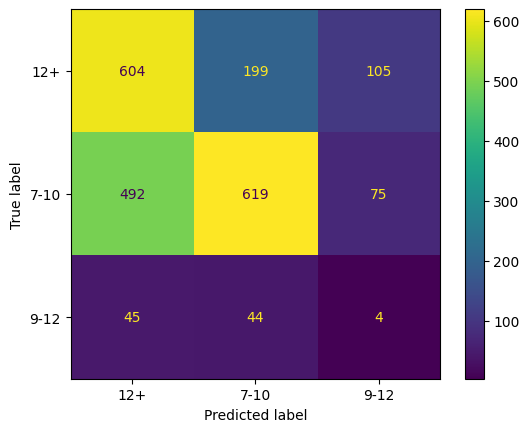

In [26]:
p[5].plot()

# Most important features comparison

In [27]:
#Reverse the dictionary
index2features = {}
for i in range(len(SNIPPET_LENS)):
    index2feature = {}
    vectorizer = vectorizers[i]
    for feature,idx in vectorizer.vocabulary_.items():
        assert idx not in index2feature #This really should hold
        index2feature[idx]=feature
    index2features[SNIPPET_LENS[i]] = index2feature
#Now we can query index2feature to get the feature names as we need

In [28]:
highest_prios = {}
for i in SNIPPET_LENS:
    classifier = classifiers[i]
    index2feature = index2features[i]
    # make a list of (weight, index), sort it
    lst=[]
    for idx,weight in enumerate(classifier.coef_[0]):
        lst.append((weight,idx))
    lst.sort() #sort

    #Print first few and last few
    #for weight,idx in lst[:20]: #first 30 (ie lowest weight)
    #    print(index2feature[idx])
    #print("----------------------------------------------------")
    #Take the last 30 (lst[-30:]) but these now come from weakest to strongest
    #so reverse the list using [::-1]
    highest_prio = []
    for weight,idx in lst[-20:][::-1]:
        highest_prio.append(index2feature[idx])
    highest_prios[i] = highest_prio

In [29]:
from pprint import pprint
pprint(highest_prios)

{'10': ['herttua',
        'juuli',
        'kopiointi',
        'valittu',
        'prinsessa',
        'täydennä',
        'mestari',
        'you',
        'sodan',
        'noita',
        'tuijotan',
        'huulet',
        'työ',
        'kävelee',
        'b',
        'sulla',
        'avaan',
        'käännyn',
        'näköjään',
        'tajuan'],
 '100': ['herttua',
         'valittu',
         'näköjään',
         'naurahti',
         'noita',
         'tuijotan',
         'juuli',
         'sanoit',
         'tajuan',
         'kulmiaan',
         'prinsessa',
         'kopiointi',
         'olis',
         'vastaa',
         'kenties',
         'kädessä',
         'vie',
         'you',
         'lähde',
         'kertoo'],
 '25': ['kopiointi',
        'herttua',
        'juuli',
        'valittu',
        'prinsessa',
        'täydennä',
        'you',
        'näköjään',
        'noita',
        'mestari',
        'käännyn',
        'huulet',
        'sulla',
        